Preamble: import these plotting utilities

In [2]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# A large matrix dataset: coauthorship among physicists

+ Coauthorship among physicists based arXiv postings in `astro-ph`
+ The graph contains $N = 18772$ nodes, which correspond to unique authors observed over the period 1993 -- 2003
+ If Author i and Author j coauthored a paper during that period, the nodes are connected
+ In order to analyze this large graph, we will downsample it to a smaller graph with $N = 1000$ nodes representing the most highly-connected authors
+ This dataset is from the [Stanford SNAP database](https://snap.stanford.edu/data/ca-CondMat.html)



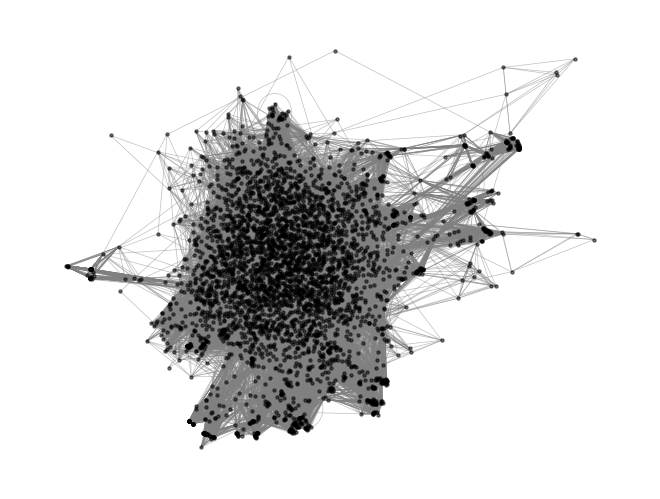

In [74]:

## Load the full coauthorship network
fpath = "../resources/ca-AstroPh.txt.gz"
# fpath = "../resources/ca-CondMat.txt.gz"
g = nx.read_edgelist(fpath)

## Create a subgraph of the 1000 most connected authors
subgraph = sorted(g.degree, key=lambda x: x[1], reverse=True)[:4000]
subgraph = [x[0] for x in subgraph]
g2 = g.subgraph(subgraph)
# rename nodes to sequential integers as they would appear in an adjacency matrix
g2 = nx.convert_node_labels_to_integers(g2, first_label=0)

pos = nx.spring_layout(g2)
# pos = nx.kamada_kawai_layout(g2)
# nx.draw_spring(g2, pos=pos, node_size=10, node_color='black', edge_color='gray', width=0.5)
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
plt.show()

# We can think of graphs as large, (often) sparse matrices

+ The adjacency matrix $A$ is a matrix of size $N \times N$ where $N$ is the number of nodes (authors)
+ $A_{ij} = 1$ if there is an edge between nodes $i$ and $j$ (i.e., if authors $i$ and $j$ have coauthored a paper). Otherwise, $A_{ij} = 0$
+ Co-authorship is an undirected graph, so $A$ is symmetric. That means that there are at most $N(N-1)/2$ unique edges in the graph.
+ Usually, there are far fewer than that.

In [75]:
A = nx.adjacency_matrix(g2).todense()
# find sparsity

n = A.shape[0]
density = np.sum(A != 0) / (n * n)
print("Density: {:.2f}%".format(density * 100))

Density: 1.26%


Let's look at this matrix a little more closely...

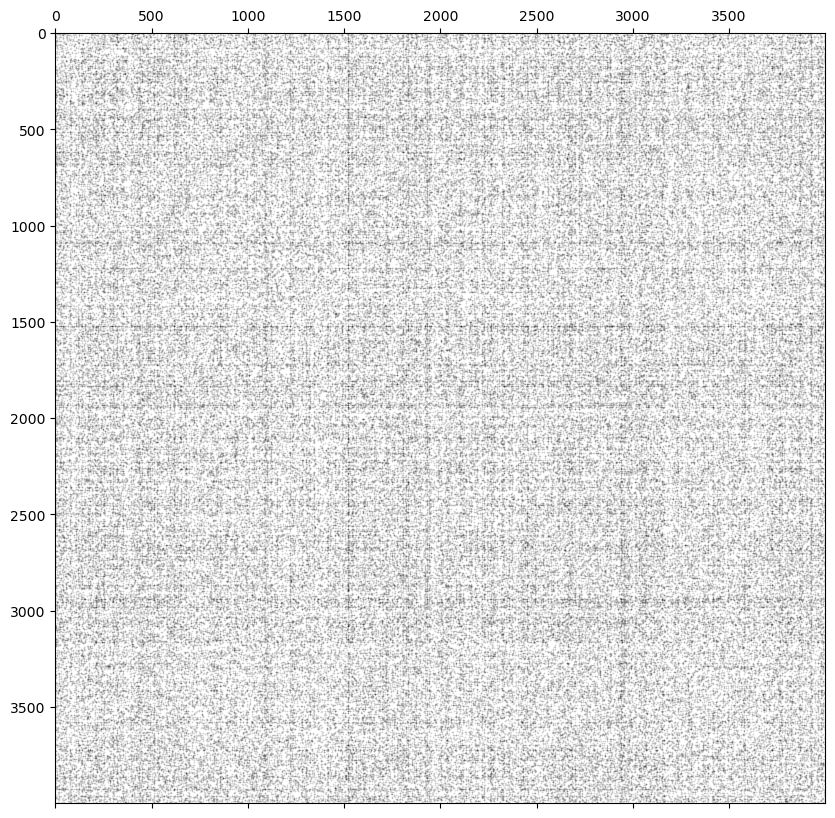

In [83]:
plt.figure(figsize=(10, 10))
plt.spy(A, markersize=0.05, color='k') # a spy plot is a plot of the sparsity pattern of a matrix

### A random walk on the graph of `astro-ph` coauthorship

+ We can think of a random walk on the graph as a random walk on the adjacency matrix $A$
+ The probability of transitioning from node $i$ to node $j$ is $A_{ij} / \sum_k A_{ik}$
+ The probability of transitioning from node $i$ to node $j$ in $n$ steps is $A^n_{ij} / \sum_k A^n_{ik}$

For the coauthorship graph, we can think of this as a highly-simplified model of collaboration: I initially collaborate with one node (like my PhD advisor). I then randomly choose one of their collaborators, and so on. 

In this simplified model, the probability of collaborating with a given author is proportional to the number of collaborators they have. So authors with high degree (many collaborators) are more likely to be chosen eventually


We thus introduce the degree distribution of the graph, which corresponds to a histogram of the number of edges per node. For this graph, the degree distribution represents the number of cumulative unique coauthors per author.

Text(0, 0.5, 'Number of Authors')

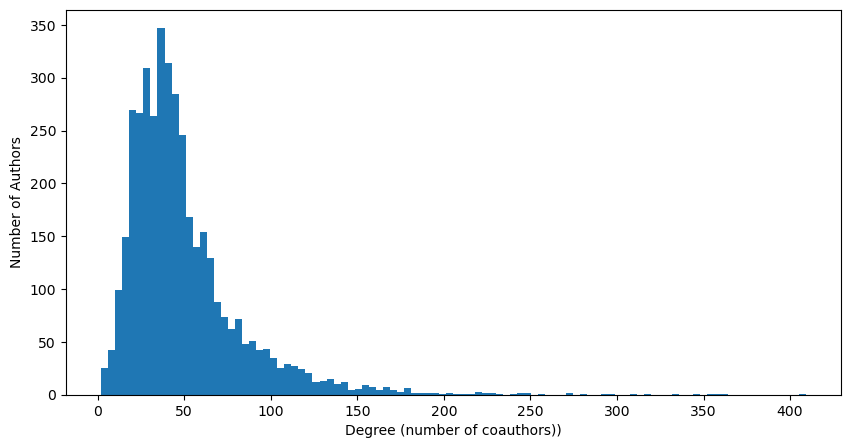

In [84]:
# degree distribution
degrees = np.sum(A, axis=0)
plt.figure(figsize=(10, 5))
plt.hist(degrees, bins=100);
plt.xlabel("Degree (number of coauthors))")
plt.ylabel("Number of Authors")


Now let's implement the random walk on the graph of `astro-ph` coauthorship.

Text(0, 0.5, 'Node')

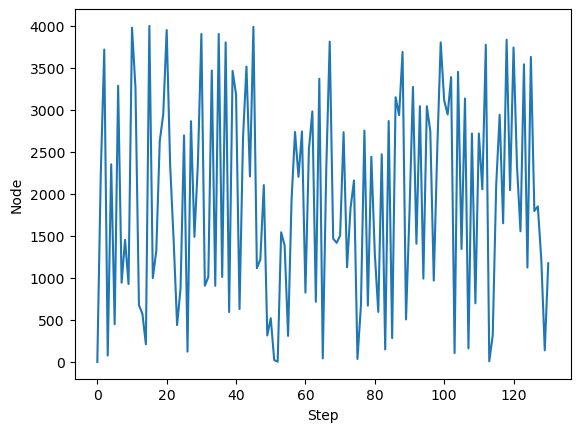

In [92]:
class GraphRandomWalk:
    """A class for performing random walks on a graph

    Parameters:
        A (np.ndarray): The adjacency matrix of the graph
        random_state (int): The random seed to use
        store_history (bool): Whether to store the history of the random walk
    """

    def __init__(self, A, random_state=None, store_history=False):
        self.A = A
        self.n = A.shape[0]
        self.degrees = np.sum(A, axis=0)
        self.D = np.diag(self.degrees)

        self.random_state = random_state
        self.store_history = store_history

        np.random.seed(self.random_state)

        if self.store_history:
            self.history = []

    def step(self, curr):
        """Take a single step from a given node

        Args:
            curr (int): The current node

        Returns:
            nxt (int): The next
        """
        choices = A[curr, :].nonzero()[0]
        nxt = np.random.choice(choices)
        return nxt


    def random_walk(self, start, steps):
        """Perform a random walk on the graph

        Args:
            start (int): The starting node
            steps (int): The number of steps to take

        Returns:
            stop (int): The final node
        """
        curr = start
        if self.store_history:
            self.history.append(start)
        for _ in range(steps):
            curr = self.step(curr)
            if self.store_history:
                self.history.append(curr)

        return curr

model = GraphRandomWalk(A, random_state=0, store_history=True)

# simulate a random walk starting from node 0 for 130 steps
model.random_walk(0, 130)

plt.plot(model.history)
plt.xlabel("Step")
plt.ylabel("Node")

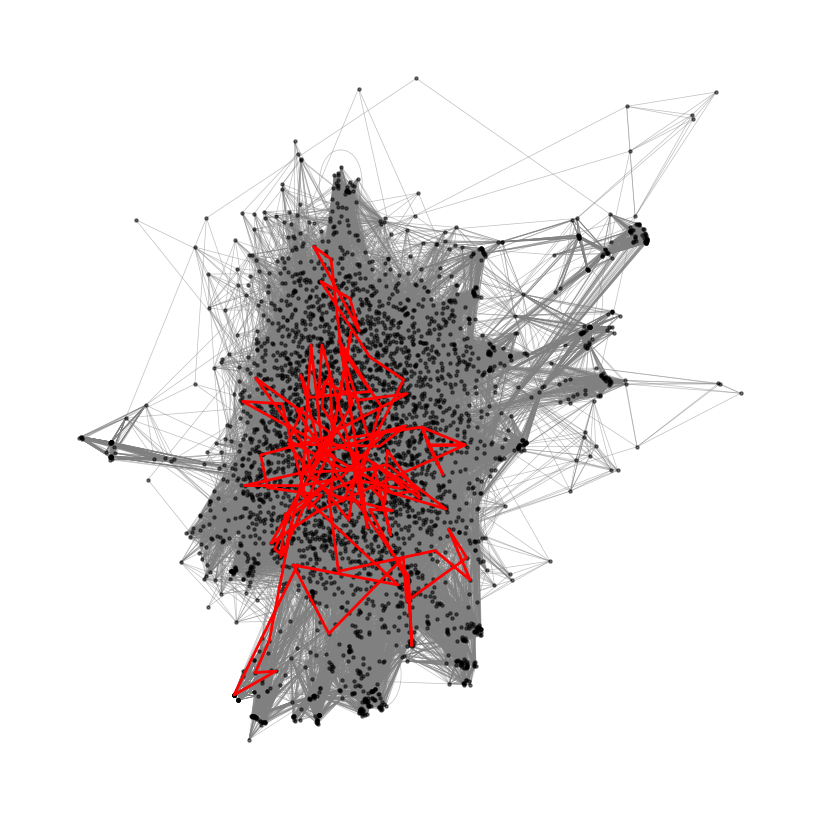

In [94]:

plt.figure(figsize=(8, 8))
nx.draw(g2, pos=pos, node_size=5, node_color='black', edge_color='gray', width=0.5, alpha=0.5)
traj = [pos[item] for item in model.history]
plt.plot(*zip(*traj), color='red', linewidth=2)
plt.show()

Now, let's simulate an ensemble of random walks on the graph of `astro-ph` coauthorship.

We will initialize each random walk at the same node (the node with the highest degree, i.e., the author with the most collaborators). We will then simulate the random walk for $n = 100$ steps.

In [100]:
all_traj = []
for _ in range(1000):
    model = GraphRandomWalk(A,  store_history=True)
    model.random_walk(0, 130)
    all_traj.append(np.array(model.history).copy())

(-0.8387362360954285,
 1.0875588059425354,
 -0.7389041513204575,
 0.7645294398069382)

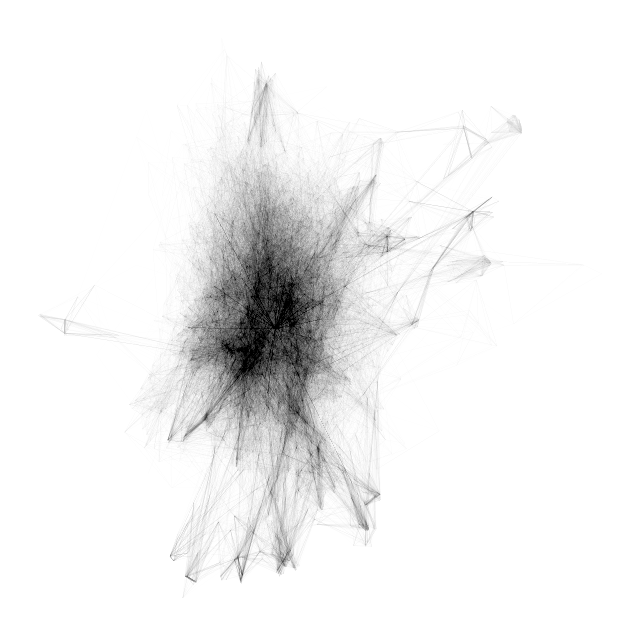

In [113]:
plt.figure(figsize=(8, 8))
for traj in all_traj:
    traj = [pos[item] for item in traj]
    plt.plot(*zip(*traj), color='k', linewidth=.2, alpha=0.01)

plt.axis('off')

# First passage times on the network of collaborators

We can see that the random walk is biased towards nodes with high degree (many collaborators). That means that the ensemble of random walks has non-uniform measure on the graph of collaborators.

Suppose we start out at the node with the highest degree. How long does it take to reach a given node? This is equivalent to the first passage time problem for a random walk on the graph.

We naively expect that the first passage time is proportional to the degree of the node. That is, the more collaborators an author has, the more likely it is that we will collaborate with them after a fixed number of steps

We will compare the first passage time between the most highly-connected node (most collaborators) and the second-most highly-connected node (second-most collaborators), as compared to the first passage time between the most highly-connected node and a less-connected node (fewer collaborators).

In [137]:
class FirstPassageTime(GraphRandomWalk):
    """A class for computing the first passage time distribution

    Parameters:
        A (np.ndarray): The adjacency matrix of the graph
        random_state (int): The random seed to use
        max_iter (int): The maximum number of iterations to use
    """

    def __init__(self, A, max_iter=10000, random_state=None, store_history=False):
        self.A = A
        self.max_iter = max_iter
        self.random_state = random_state
        self.store_history = store_history
        np.random.seed(self.random_state)

        if self.store_history:
            self.history = []


    def fpt(self, start, stop):
        """Compute the first passage time distribution

        Args:
            start (int): The starting node
            stop (int): The stopping node
            steps (int): The maximum number of steps to take

        Returns:
            fpt (int): The first passage time
        """
        curr = start
        if self.store_history:
            self.history.append(start)
        for i in range(self.max_iter):
            curr = self.step(curr)
            if self.store_history:
                self.history.append(curr)
            if curr == stop:
                return i

        return np.inf

fpt = FirstPassageTime(A, random_state=0, store_history=True, max_iter=100000)
fpt.fpt(0, 10)

2768

In [148]:
all_paths_close, all_fpts_close = [], []
all_paths_far, all_fpts_far = [], []
fpt = FirstPassageTime(A, store_history=True, max_iter=100000)
for _ in range(1000):
    all_fpts_close.append(fpt.fpt(0, 1))
    all_paths_close.append(fpt.history)

    all_fpts_far.append(fpt.fpt(0, 15))
    all_paths_far.append(fpt.history)

# print number that didn't converge within max_iter
print("Number of paths that didn't converge within max_iter: {}".format(np.sum(np.isinf(all_fpts_close))))
print("Number of paths that didn't converge within max_iter: {}".format(np.sum(np.isinf(all_fpts_far))))

Number of paths that didn't converge within max_iter: 0
Number of paths that didn't converge within max_iter: 0


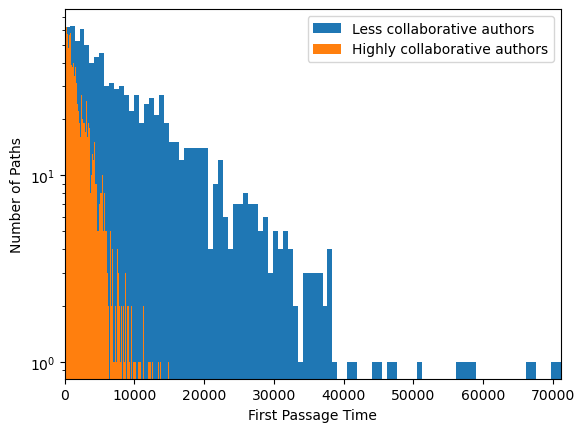

In [155]:
plt.semilogy()
plt.hist(all_fpts_far, bins=100, alpha=1, label="Less collaborative authors");
plt.hist(all_fpts_close, bins=100, alpha=1, label="Highly collaborative authors");
plt.xlabel("First Passage Time")
plt.ylabel("Number of Paths")
plt.xlim([0, np.max(all_fpts_far)])
plt.legend()


In [156]:
# plot all FPT paths
plt.figure(figsize=(8, 8))
for traj in all_paths[:2]:
    traj = [pos[item] for item in traj]
    plt.plot(*zip(*traj), color='k', linewidth=.2, alpha=0.01)


OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 800x800 with 1 Axes>

# Can we compute this analytically?

We can now compute the first passage time analytically. Much as we previously saw with random walks on the line, we can pass between the dynamics of single walkers (particles), and the dynamics of a distribution (ensemble). From the adjacency matrix $A$, we can construct a transition matrix $T$ such that

$$
T_{ij} = \frac{A_{ij}}{\sum_k A_{ik}}
$$

This matrix defines a discrete-time Markov chain on the graph. Given a *starting distribution* $\pi_0 \in \mathbb{R}^N$, we can compute the distribution of the random walk after $n$ steps as

$$
\pi_n = T^n \pi_0 
$$

where $\pi_n$ is the distribution of the random walk after $n$ steps, and $T^n$ is the transition matrix applied $n$ times.

In the case above, our starting distribution is $\pi_0 = \delta_{i, \text{max}}$, where $\delta_{i, \text{max}}$ is the Kronecker delta function, which is 1 if $i = \text{max}$ and 0 otherwise. That is, we always start out at the node with the highest degree.


In [ ]:
# plot the shortest path
shortest_path = nx.shortest_path(g2, source=0, target=10)
shortest_path = [pos[item] for item in shortest_path]
plt.plot(*zip(*shortest_path), color='red', linewidth=2)
plt.axis('off')


The first passage time is indeed proportional to the degree of the node. That is, the more collaborators an author has, the more likely it is that we will collaborate with them after a fixed number of steps. We can now use matrix inversion to compute the first passage time for all nodes in the graph.

# Matrix inversion

We can now use matrix inversion to compute the first passage time for all nodes in the graph. If the adjacency matrix is $A$, then the first passage time matrix is $T = (I - A)^{-1}$


ValueError: supplied range of [6.0, inf] is not finite

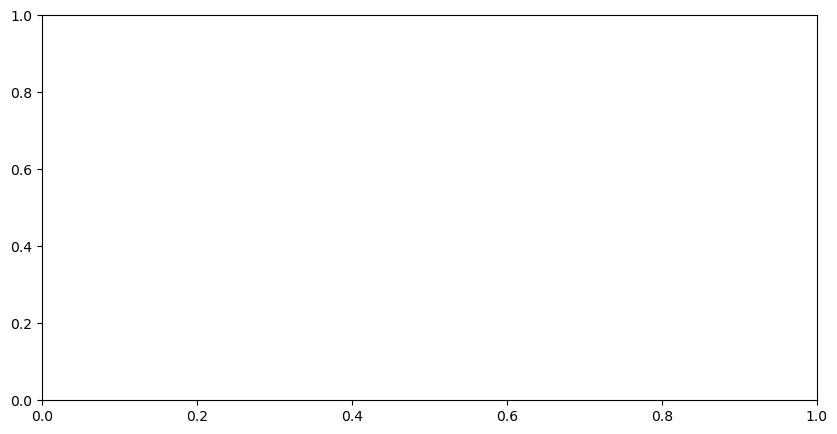

In [123]:
# plot fpts
plt.figure(figsize=(10, 5))
plt.hist(fpts, bins=100);
plt.xlabel("First Passage Time")
plt.ylabel("Number of Samples")

In [86]:
# get node names in order they appear in adjacency matrix
nodes = list(g2.nodes())
# get look up node names from path

[array([-0.01445583, -0.01388113]),
 array([-0.03753622, -0.16940807]),
 array([-0.19819987,  0.00482467]),
 array([ 0.04358821, -0.00032789]),
 array([0.11276685, 0.04642106]),
 array([0.01283794, 0.02418415]),
 array([-0.06323504,  0.24000229]),
 array([0.02183973, 0.12529474]),
 array([-0.140211  ,  0.11115914]),
 array([-0.16519928,  0.16269746]),
 array([-0.10774763, -0.03182479]),
 array([-0.09916919,  0.01343606]),
 array([ 0.01154318, -0.02891263]),
 array([ 0.10591201, -0.0939597 ]),
 array([ 0.09721501, -0.09689027]),
 array([-0.02112904, -0.07668151]),
 array([-0.09249412, -0.10348628]),
 array([-0.06519931, -0.28604096]),
 array([ 0.19095391, -0.23876196]),
 array([ 0.28345621, -0.30579382]),
 array([ 0.2267632 , -0.18976358]),
 array([ 0.27455938, -0.25512084]),
 array([ 0.11524993, -0.35477501]),
 array([ 0.10705801, -0.25411239]),
 array([-0.09055513, -0.42866921]),
 array([-0.18467951, -0.27181771]),
 array([ 0.09253345, -0.31709963]),
 array([-0.16862993, -0.1056812 ])

# Inverting a matrix

We are still trying to solve the linear equation
$$
A \mathbf{x} = \mathbf{b}
$$

Which requires us to construct the matrix $A^{-1}$
$$
\mathbf{x} = A^{-1} \mathbf{b}
$$

How would we do this by hand?

Gauss-Jordan elimination: perform a series of operations on both the left and the right hand sides of our equation (changing both $A$ and $\mathbf{b}$), until the left side of the equation is triangular in form. Because Gauss-Jordan elimination consists of a series of row-wise addition and subtraction operations, we can think of the process as writing each row vector in terms of some linear combination of row vectors, making the whole process expressible as a matrix $M$

$$
(M A) \mathbf{x} = M \mathbf{b} \\
$$
$$
U \mathbf{x} = M \mathbf{b} \\
$$
where we have defined the upper-triangular matrix $U \equiv MA$. This confirms our intuition that the time complexity of Gauss-Jordan elimination is $\sim\mathcal{O}(N^3)$, since that's the time complexity of multiplying two $N \times N$ matrices.

#### Why do we want triangular matrices?

If we can reduce our matrix $A$ to upper-triangular form, then we can quickly solve for $\mathbf{x}$ using forward substitution. This should take $\sim\mathcal{O(N^2)}$ operations if $A \in \mathbb{R}^{N \times N}$

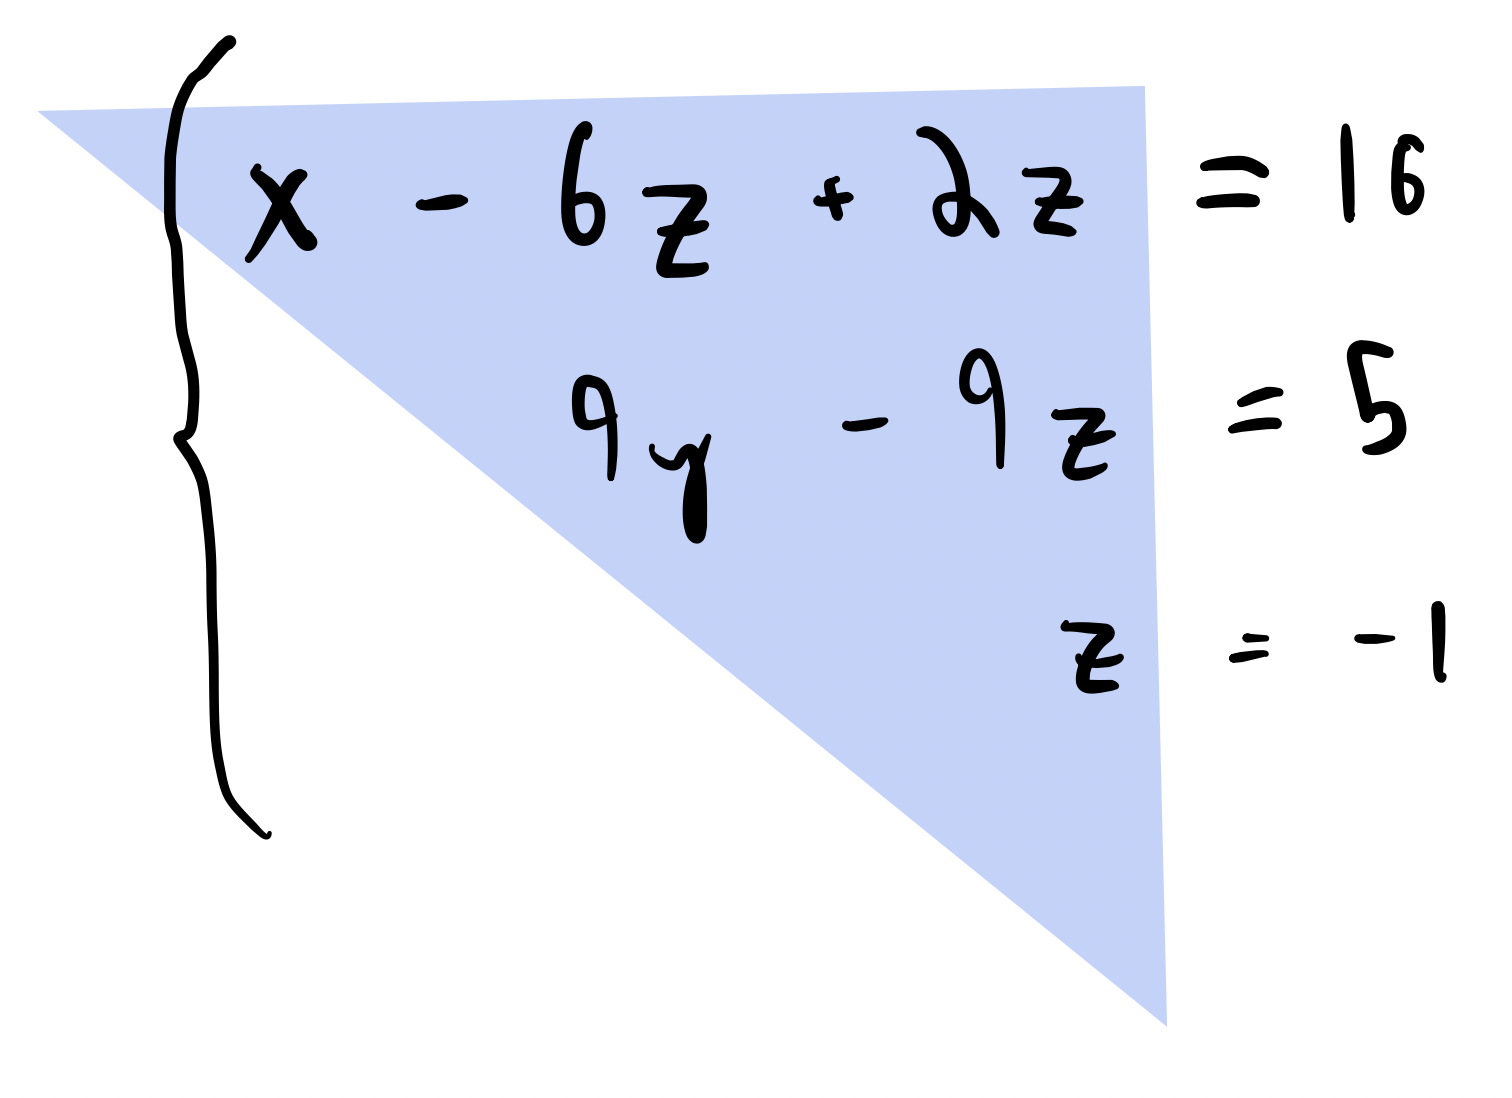

In [3]:
Image("../resources/triangular.png", width=600)

In [117]:

def solve_tril(a, b):
    """
    Given a triangular matrix, solve using forward subtitution

    Args:
        a (np.ndarray): A lower triangular matrix
        b (np.ndarray): A vector

    Returns:
        x (np.ndarray): The solution to the system
    """
    #a = a.T # make it lower triangular for cleaner notation
    n = a.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - np.dot(a[i, :i], x[:i])) / a[i, i]
    return x
    
# A random lower triangular matrix
a = np.tril(np.random.random((10, 10)))
b = np.random.random(10)

print(np.linalg.solve(a, b))
print(solve_tril(a, b))

# Check that the numpy and our implementation give the same result
print(np.allclose(np.linalg.solve(a, b), solve_tril(a, b)))



[  0.65992466   0.32830238  -0.25257279   3.48492801  -5.93032238
  -2.57856074  19.46271838 -14.46514234  73.19753098 -84.13021322]
[  0.65992466   0.32830238  -0.25257279   3.48492801  -5.93032238
  -2.57856074  19.46271838 -14.46514234  73.19753098 -84.13021322]
True


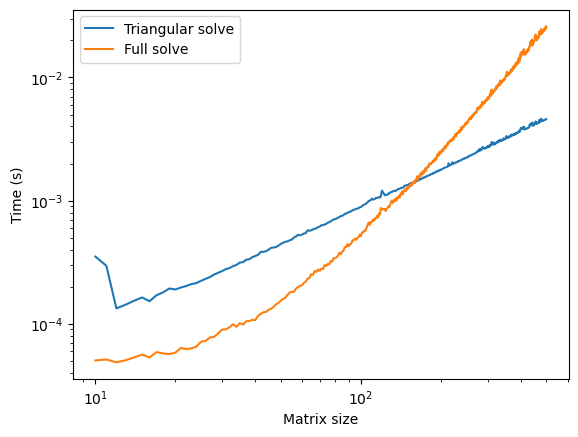

In [121]:
import timeit

all_times1, all_times2 = list(), list()
nvals = np.arange(10, 500)
for n in nvals:
    ## Upper triangular solve
    a = np.tril(np.random.random((n, n)))
    b = np.random.random(n)
    all_reps = [timeit.timeit("solve_tril(a, b)", globals=globals(), number=10) for _ in range(10)]
    all_times1.append(np.mean(all_reps))

    ## Full solve
    a = np.random.random((n, n))
    b = np.random.random(n)
    all_reps = [timeit.timeit("np.linalg.solve(a, b)", globals=globals(), number=10) for _ in range(10)]
    all_times2.append(np.mean(all_reps))

plt.loglog(nvals, all_times1, label="Triangular solve")
plt.loglog(nvals, all_times2, label="Full solve")
plt.xlabel("Matrix size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

## So to invert a matrix, we just need to reach triangular form

We know that we want to modify our full matrix equation 
$$
A \mathbf{x} = \mathbf{b}
$$ 
using a Gauss-Jordan elimination procedure, which we know has the form of a matrix multiplication
$$
M A \mathbf{x} = M \mathbf{b}
$$ 
We define $U \equiv M A$, and we know that we want to reduce $U$ to upper-triangular form.
$$
U \mathbf{x} = M \mathbf{b}
$$
But what is the form of $M$? 

**Our key insight is that the matrix $M$ turns out to be a triangular matrix as well.**

Moreover, because the inverse of a triangular matrix is also a triangular matrix (this can be proven by writing out the matrix multiplication algebra for $U^{-1} U = I$), we therefore write a transformed version of our problem

$$
U \mathbf{x} = M \mathbf{b}
$$
defining $M \equiv L^{-1}$, we arrive at the celebrated LU matrix factorization 
$$
L U \mathbf{x} = \mathbf{b}
$$
where $L$ is a lower triangular matrix, and $U$ is an upper triangular matrix.

We can therefore solve for $\mathbf{x}$ by introducing an intermediate variable $\mathbf{h}$, and then $\mathbf{x}$
$$
LU \mathbf{x} = \mathbf{b} \\
L \mathbf{h} = \mathbf{b} \\
$$
where $\mathbf{h} \equiv U \mathbf{x}$. 

Our solution thus consists of the following steps:
1. Solve the equation $\mathbf{h} = L^{-1} \mathbf{b}$. Since $L$ is a triangular matrix, this can be performed using substitution
2. Solve the equation $\mathbf{x} = U^{-1} \mathbf{h}$. Since $U$ is also triangular, this is also fast

## Solving for LU

+ Naive iterative implementation uses Gauss-Jordan elimination in a principled order
+ A more sophisticated algorithm called Crout's method with pivoting, which performs optimal order of decomposition based on the specific values present in a given row or column
+ Decomposition into L and U is $\sim \mathcal{O}(N^3)$ for an $N \times N$ matrix
+ Given a matrix $A$ and target $\mathbf{b}$, what is the overall runtime to find $\mathbf{x}$?


# Pseudocode for LU decomposition

```
U = A, L = I
for j = 1 : n - 1 do
    for i = j + 1 : n do
        L[i, j] = U[i, j] / U[j, j]
        for k = j : n do
            U[i, k] = U[i, k] - L[i, j] * U[j, k]
        end
    end
end
```

+ In the context of the LU decomposition algorithm, the 'pivot' refers to the diagonal element in the current column, denoted as $U_{jj}$, that we are processing in the outer loop. The pivot serves as a divisor to find the multipliers $L_{ij}$ which are then used to eliminate the elements below the pivot, making them zero to carve out an upper triangular matrix $U$.

+ Simultaneously, these multipliers are stored in the lower triangular matrix $L$. Essentially, we are utilizing the pivot to find scalar values that can help perform row operations to systematically zero out elements below the diagonal in $U$, while building up the $L$ matrix.

+ We can see that there are three nested loops, which means that the time complexity of the LU decomposition algorithm is $\sim \mathcal{O}(N^3)$.

In [2]:
class LinearSolver:
    """
    Solve a linear matrix equation via LU decomposition (naive algorithm)
    """
    def __init__(self):
        # Run a small test upon construction
        self.test_lu()

    def lu(self, a):
        """Perform LU factorization of a matrix"""
        n = a.shape[0]
        L, U = np.identity(n), np.copy(a)
        for i in range(n):
            factor = U[i+1:, i] / U[i, i]
            L[i + 1:, i] = factor
            U[i + 1:] -= factor[:, None] * U[i]
        return L, U

    def test_lu(self):
        """A small test method that the factorization is correct"""
        X = np.random.random((10, 10))
        L, U = self.lu(X)
        assert np.allclose(X, L @ U), "LU decomposition failed"

    def forward_substitution(self, L, b):
        """Solve a lower triangular matrix equality of the form Lx = b for x"""
        n = L.shape[0]
        y = np.zeros(n)
        y[0] = b[0] / L[0, 0]
        for i in range(1, n):
            y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        return y
        
    def backward_substitution(self, U, b):
        """Solve an upper triangular matrix equality of teh form Ux = b for x"""
        n = U.shape[0]
        y = np.zeros(n)
        y[-1] = b[-1] / U[-1, -1]
        for i in range(n-2, -1, -1):
            y[i] = (b[i] - np.dot(U[i,i+1:], y[i+1:])) / U[i,i]
        return y
        
    def solve(self, X, b):
        L, U = self.lu(X)
        self.L, self.U = L, U

        # Intermediate variable
        h = self.forward_substitution(L, b)
        
        return self.backward_substitution(U, h)
        
        
        
A = np.random.rand(4, 4)
b = np.random.rand(4)

model = LinearSolver()
print(model.solve(A, b))

# Using the numpy built-in solver
print(np.linalg.solve(A, b))



[ 0.52707115  1.09551142 -0.8144515   0.90652132]
[ 0.52707115  1.09551142 -0.8144515   0.90652132]


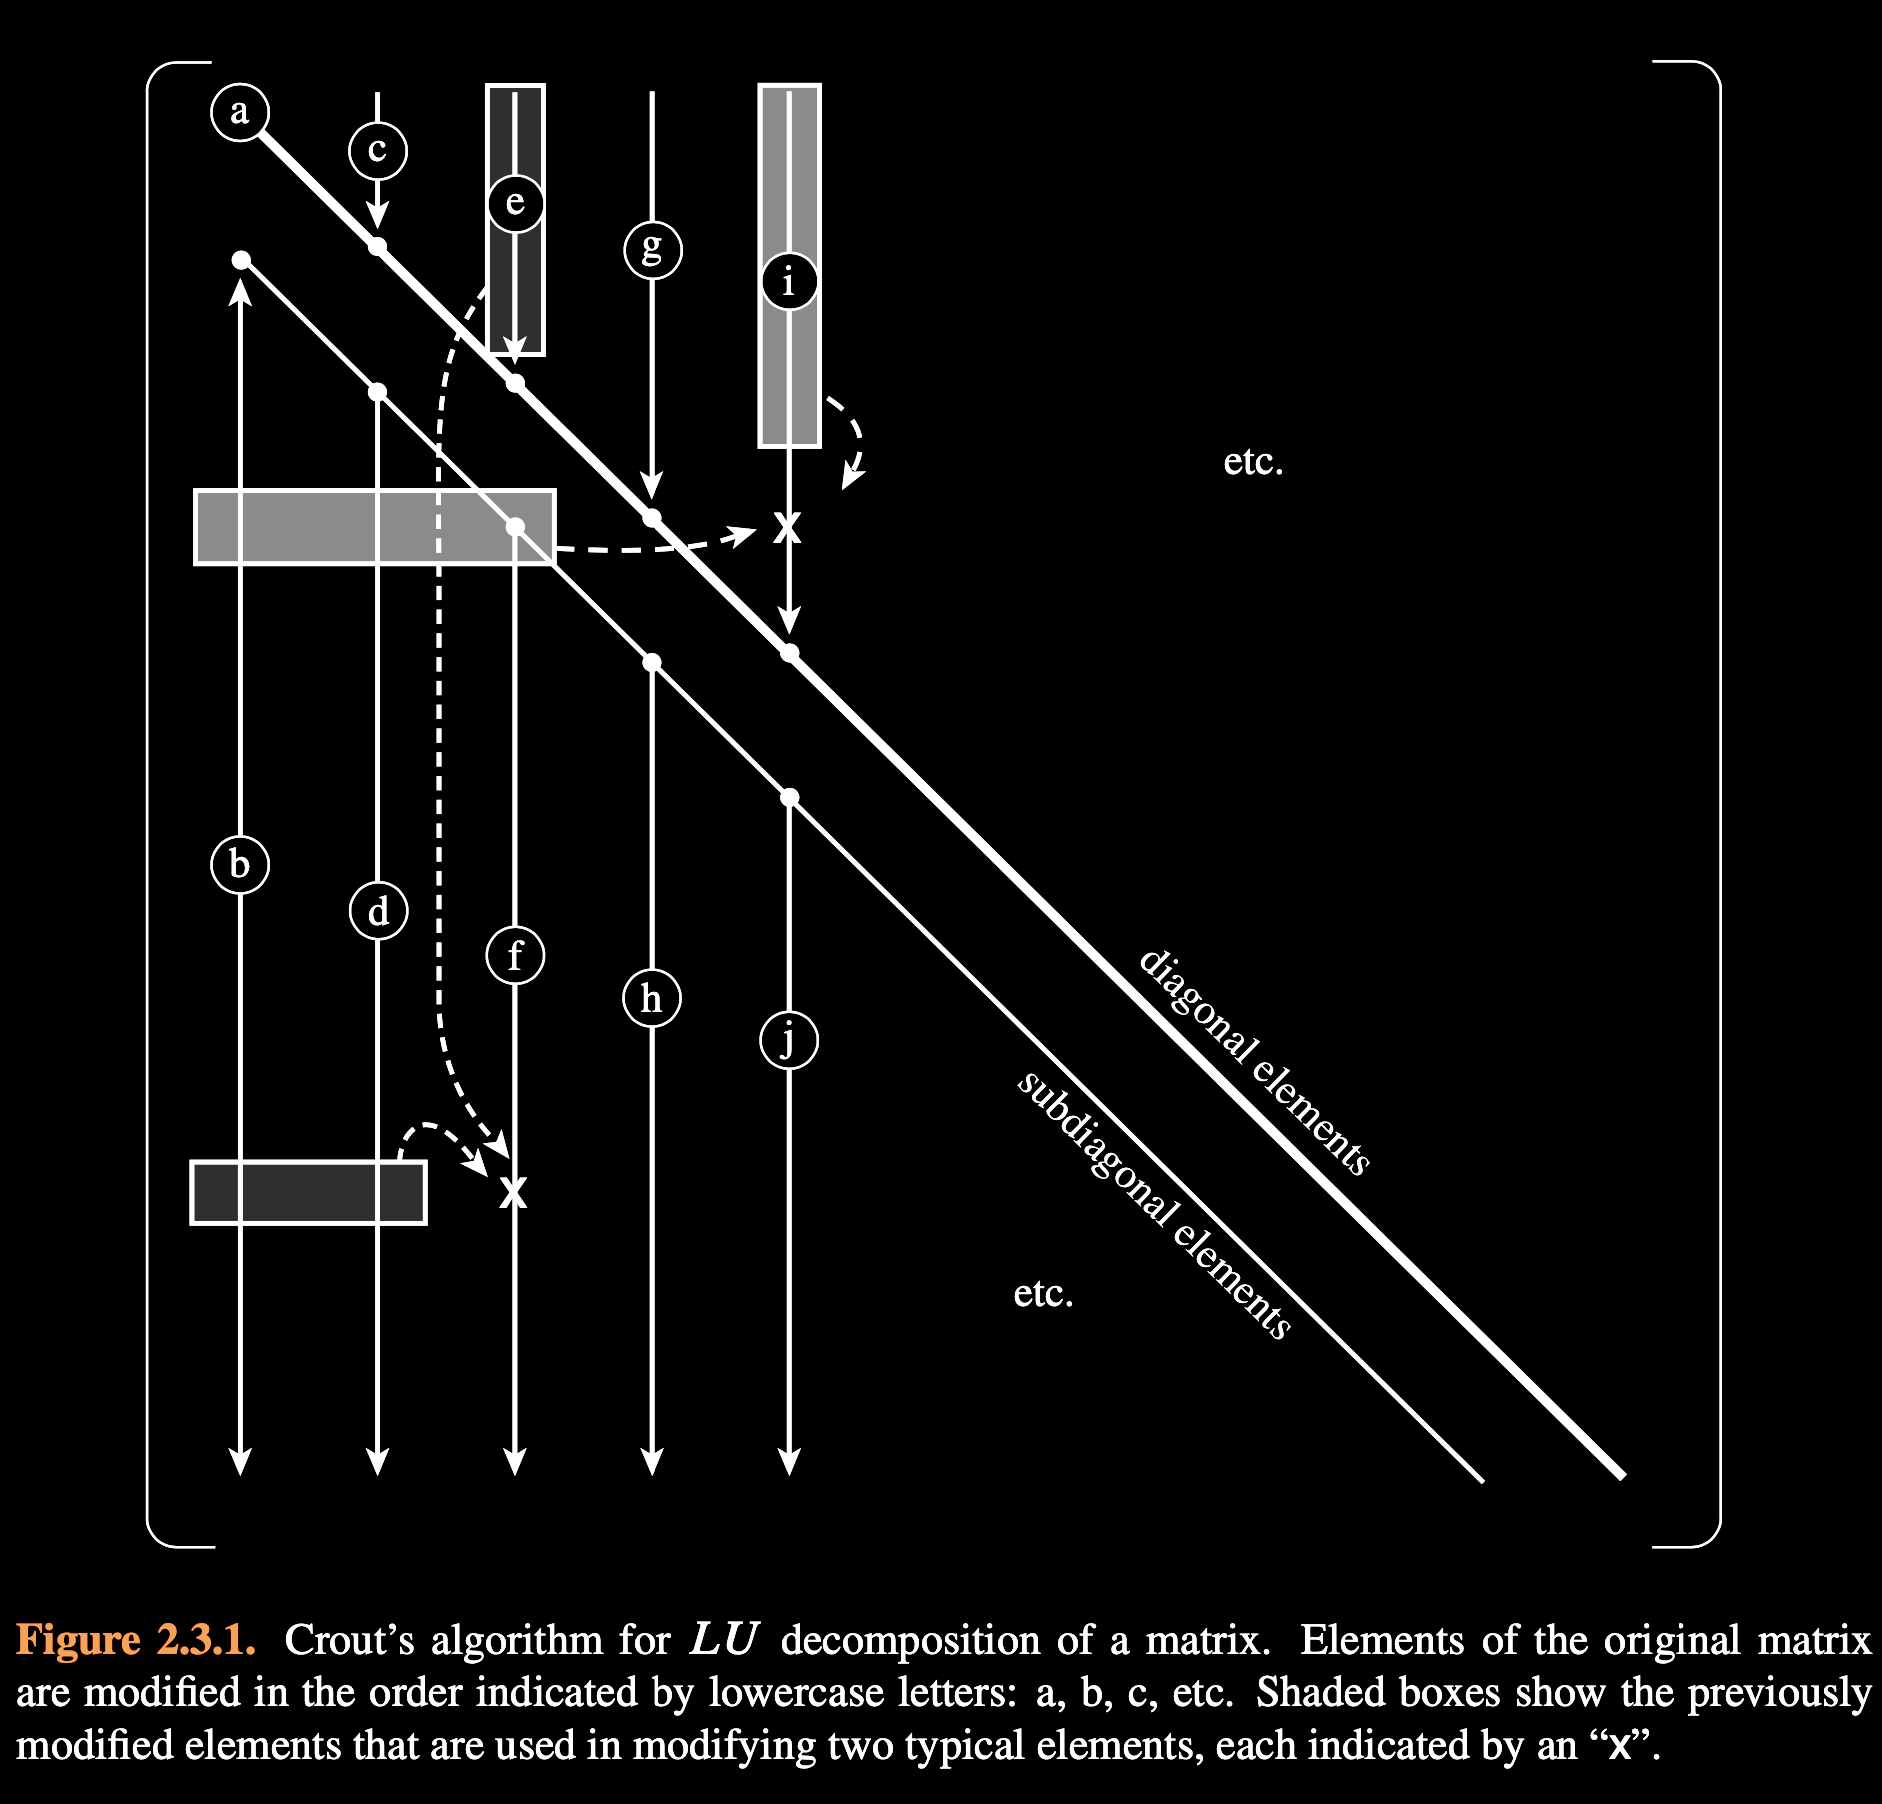

In [10]:
# A more efficient order of steps: Crout's algorithm
display(Image(filename='../resources/crout_diagram.png', width=700))
## Source: Press Numerical Recipes textbook

## LU Decomposition of orthogonal basis sets

+ A Hadamard matrix is a square matrix comprising a complete collection of length $N$ mutually-orthogonal vectors with all elements equal to either $+1$ or $-1$
+ We can convert any complete orthonormal basis to a Hadamard matrix by ordering the vectors systematically, and substituting $0$ and $1$ for $\pm 1$ with an appropriate rule

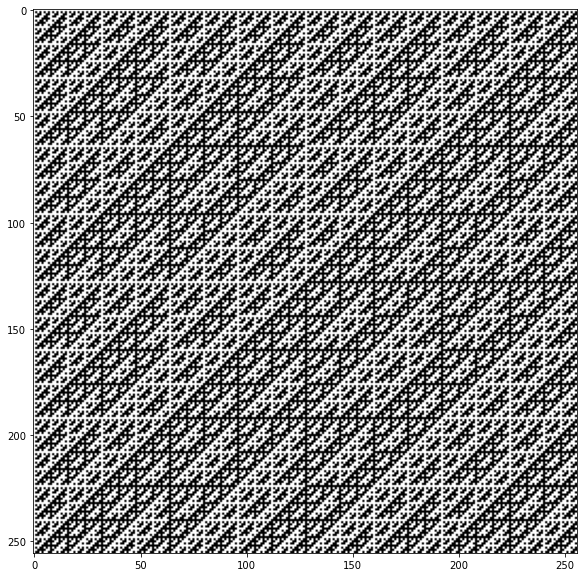

In [33]:
from scipy.linalg import hadamard

plt.figure(figsize=(10, 10))
a = hadamard(2**8).astype(float)

plt.imshow(a, cmap='gray')


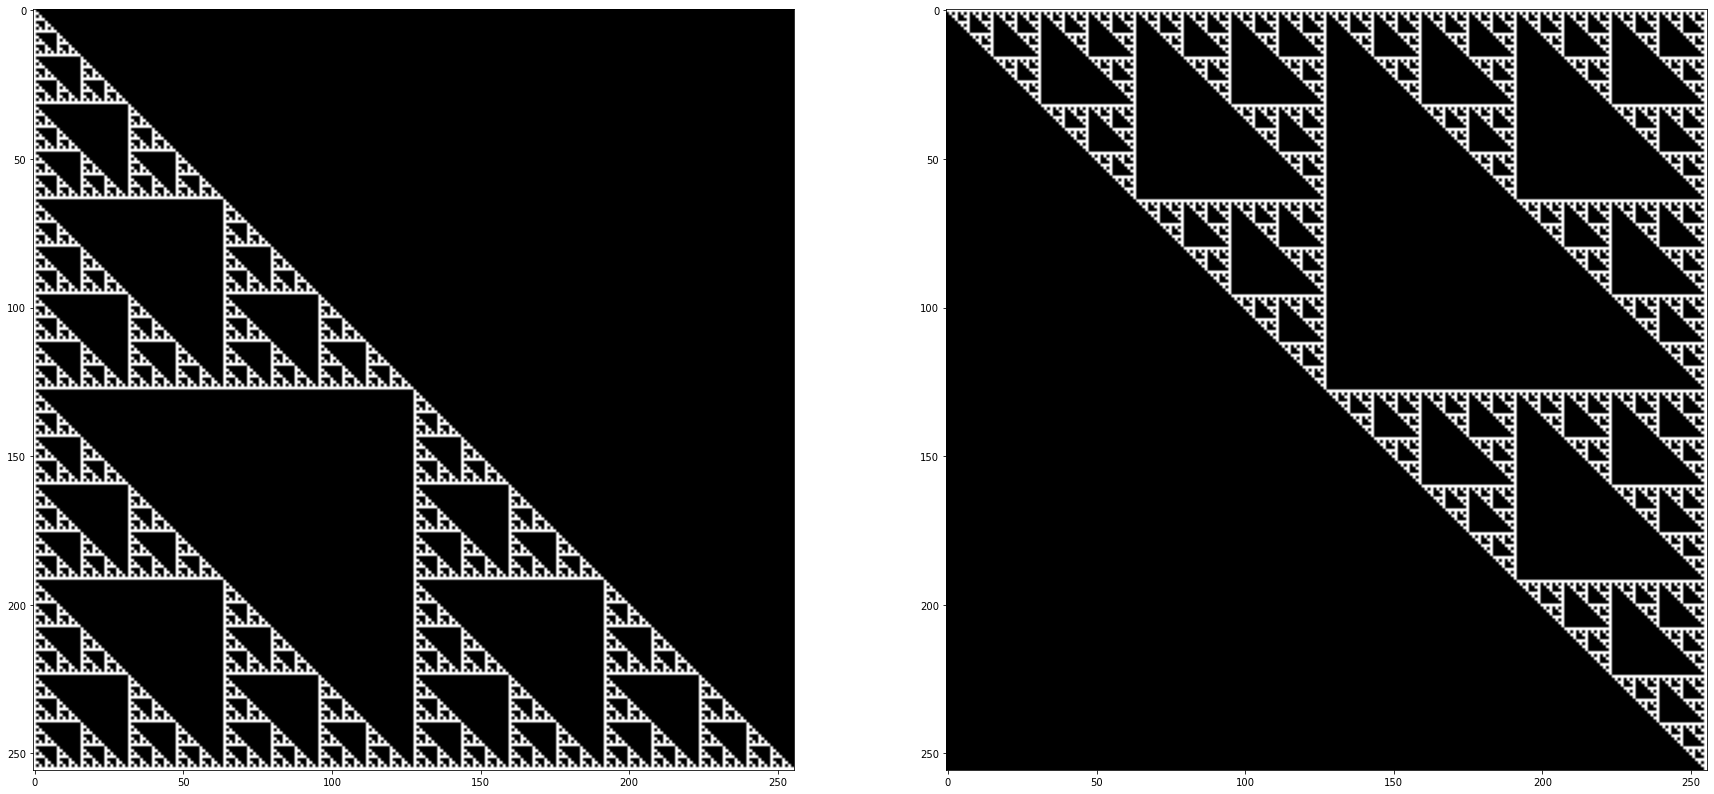

In [32]:


ll, uu = model.lu(a)


plt.figure(figsize=(30, 15))
plt.subplot(121)
plt.imshow(ll, cmap='gray')
plt.subplot(122)
plt.imshow(uu.astype(bool), cmap='gray')
